# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [144]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [145]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [146]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [147]:
## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [148]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = torch.nn.Linear(z_dim, 256) # FILL IN HERE
    self.fc2 = torch.nn.Linear(256, 512) # FILL IN HERE
    self.fc3 = torch.nn.Linear(512, 784) # FILL IN HERE
  def forward(self, z):
    h = F.leaky_relu(self.fc1(z), 0.2)
    h = F.leaky_relu(self.fc2(h), 0.2)
    y = F.tanh(self.fc3(h)) # FILL IN HERE
    y = y.view((-1, n_channels, n_rows, n_cols))
    return(y)


In [149]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.n_pixels*n_channels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    x = x.view(-1, self.n_pixels*self.n_channels) # flattens x 
    h = F.leaky_relu(self.fc1(x), 0.2)
    h =  F.leaky_relu(self.fc2(h), 0.2)
    y =  F.sigmoid(self.fc3(h)) # FILL IN HERE
    return y




Create generator and discriminator 

In [150]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels) # FILL IN HERE
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [151]:

# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = torch.nn.BCELoss() # FILL IN HERE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))  # FILL IN CODE
  return loss_gen

	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [152]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device='cpu') #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.4496	Loss_G: -0.6675	D(x): 0.4578	D(G(z)): 0.4873


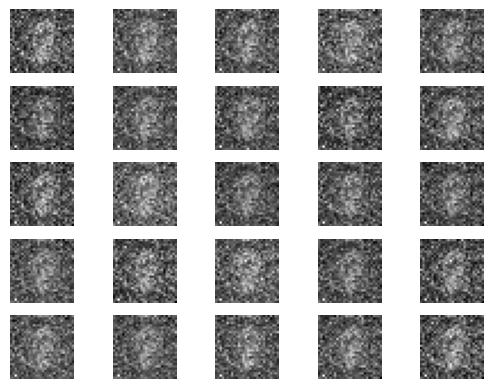

[1/400][0/16] 	Loss_D: 0.9880	Loss_G: -0.7537	D(x): 0.8562	D(G(z)): 0.5647
[2/400][0/16] 	Loss_D: 1.1756	Loss_G: -0.7512	D(x): 0.7406	D(G(z)): 0.5821
[3/400][0/16] 	Loss_D: 1.1560	Loss_G: -0.6021	D(x): 0.7036	D(G(z)): 0.5514
[4/400][0/16] 	Loss_D: 1.3751	Loss_G: -0.6330	D(x): 0.6582	D(G(z)): 0.6140
[5/400][0/16] 	Loss_D: 1.3590	Loss_G: -0.6304	D(x): 0.4615	D(G(z)): 0.4202
[6/400][0/16] 	Loss_D: 0.3255	Loss_G: -0.1574	D(x): 0.8925	D(G(z)): 0.1899
[7/400][0/16] 	Loss_D: 0.1272	Loss_G: -0.0632	D(x): 0.9467	D(G(z)): 0.0683
[8/400][0/16] 	Loss_D: 3.2478	Loss_G: -1.5336	D(x): 0.6560	D(G(z)): 0.9364
[9/400][0/16] 	Loss_D: 0.0838	Loss_G: -0.0385	D(x): 0.9612	D(G(z)): 0.0429
[10/400][0/16] 	Loss_D: 0.0335	Loss_G: -0.0163	D(x): 0.9844	D(G(z)): 0.0175
[11/400][0/16] 	Loss_D: 0.0202	Loss_G: -0.0108	D(x): 0.9915	D(G(z)): 0.0115
[12/400][0/16] 	Loss_D: 0.0160	Loss_G: -0.0087	D(x): 0.9934	D(G(z)): 0.0093
[13/400][0/16] 	Loss_D: 0.0137	Loss_G: -0.0072	D(x): 0.9938	D(G(z)): 0.0074
[14/400][0/16] 	Loss_

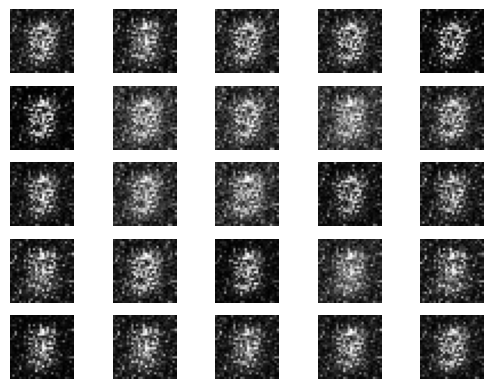

[26/400][0/16] 	Loss_D: 0.6933	Loss_G: -0.2430	D(x): 0.7995	D(G(z)): 0.3449
[27/400][0/16] 	Loss_D: 0.7220	Loss_G: -0.1198	D(x): 0.9165	D(G(z)): 0.4528
[28/400][0/16] 	Loss_D: 1.2804	Loss_G: -0.2912	D(x): 0.9186	D(G(z)): 0.6673
[29/400][0/16] 	Loss_D: 0.5755	Loss_G: -0.2562	D(x): 0.8626	D(G(z)): 0.2777
[30/400][0/16] 	Loss_D: 1.0743	Loss_G: -0.3918	D(x): 0.8522	D(G(z)): 0.4666
[31/400][0/16] 	Loss_D: 1.0150	Loss_G: -0.2332	D(x): 0.9033	D(G(z)): 0.5407
[32/400][0/16] 	Loss_D: 0.7956	Loss_G: -0.9814	D(x): 0.5839	D(G(z)): 0.1971
[33/400][0/16] 	Loss_D: 0.9135	Loss_G: -0.4702	D(x): 0.6109	D(G(z)): 0.3242
[34/400][0/16] 	Loss_D: 1.2060	Loss_G: -0.8942	D(x): 0.3931	D(G(z)): 0.1666
[35/400][0/16] 	Loss_D: 0.8247	Loss_G: -0.3494	D(x): 0.5921	D(G(z)): 0.2331
[36/400][0/16] 	Loss_D: 0.8766	Loss_G: -0.3260	D(x): 0.6901	D(G(z)): 0.3679
[37/400][0/16] 	Loss_D: 0.7048	Loss_G: -0.1125	D(x): 0.8487	D(G(z)): 0.4066
[38/400][0/16] 	Loss_D: 0.6516	Loss_G: -0.0973	D(x): 0.8326	D(G(z)): 0.3559
[39/400][0/1

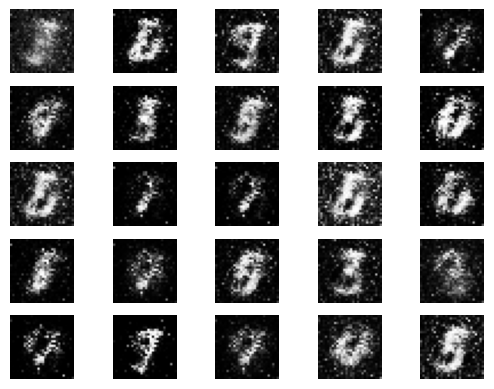

[51/400][0/16] 	Loss_D: 0.7661	Loss_G: -0.4771	D(x): 0.6360	D(G(z)): 0.2168
[52/400][0/16] 	Loss_D: 0.9822	Loss_G: -0.6180	D(x): 0.5232	D(G(z)): 0.1935
[53/400][0/16] 	Loss_D: 0.8863	Loss_G: -0.2921	D(x): 0.6902	D(G(z)): 0.3470
[54/400][0/16] 	Loss_D: 1.3390	Loss_G: -0.2005	D(x): 0.8059	D(G(z)): 0.6101
[55/400][0/16] 	Loss_D: 0.7877	Loss_G: -0.2174	D(x): 0.7052	D(G(z)): 0.3230
[56/400][0/16] 	Loss_D: 0.8711	Loss_G: -0.6189	D(x): 0.6087	D(G(z)): 0.2391
[57/400][0/16] 	Loss_D: 0.8321	Loss_G: -0.6117	D(x): 0.5656	D(G(z)): 0.1786
[58/400][0/16] 	Loss_D: 0.9304	Loss_G: -0.1682	D(x): 0.8349	D(G(z)): 0.4893
[59/400][0/16] 	Loss_D: 0.7800	Loss_G: -0.6681	D(x): 0.5966	D(G(z)): 0.1711
[60/400][0/16] 	Loss_D: 1.5360	Loss_G: -0.0576	D(x): 0.9280	D(G(z)): 0.7179
[61/400][0/16] 	Loss_D: 1.2928	Loss_G: -0.6887	D(x): 0.3543	D(G(z)): 0.0463
[62/400][0/16] 	Loss_D: 1.0391	Loss_G: -0.5309	D(x): 0.4416	D(G(z)): 0.0533
[63/400][0/16] 	Loss_D: 2.4779	Loss_G: -0.1489	D(x): 0.9801	D(G(z)): 0.8921
[64/400][0/1

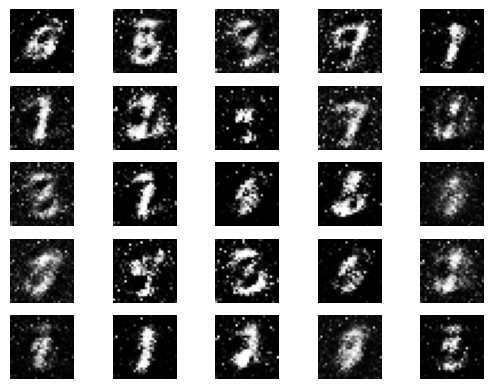

[76/400][0/16] 	Loss_D: 1.5033	Loss_G: -0.9294	D(x): 0.3443	D(G(z)): 0.0646
[77/400][0/16] 	Loss_D: 0.7630	Loss_G: -0.3550	D(x): 0.6127	D(G(z)): 0.1553
[78/400][0/16] 	Loss_D: 0.6139	Loss_G: -0.3352	D(x): 0.7704	D(G(z)): 0.2517
[79/400][0/16] 	Loss_D: 0.5608	Loss_G: -0.2667	D(x): 0.7334	D(G(z)): 0.1696
[80/400][0/16] 	Loss_D: 0.6452	Loss_G: -0.6285	D(x): 0.6657	D(G(z)): 0.1216
[81/400][0/16] 	Loss_D: 0.7818	Loss_G: -0.4637	D(x): 0.5570	D(G(z)): 0.0503
[82/400][0/16] 	Loss_D: 0.4757	Loss_G: -0.1417	D(x): 0.8476	D(G(z)): 0.2463
[83/400][0/16] 	Loss_D: 0.6793	Loss_G: -0.0592	D(x): 0.9014	D(G(z)): 0.3978
[84/400][0/16] 	Loss_D: 0.7519	Loss_G: -0.0487	D(x): 0.9545	D(G(z)): 0.4725
[85/400][0/16] 	Loss_D: 1.0850	Loss_G: -0.6316	D(x): 0.4633	D(G(z)): 0.0235
[86/400][0/16] 	Loss_D: 1.0908	Loss_G: -0.2903	D(x): 0.4667	D(G(z)): 0.0247
[87/400][0/16] 	Loss_D: 0.5906	Loss_G: -0.5171	D(x): 0.7070	D(G(z)): 0.1224
[88/400][0/16] 	Loss_D: 0.7302	Loss_G: -0.3033	D(x): 0.6288	D(G(z)): 0.0644
[89/400][0/1

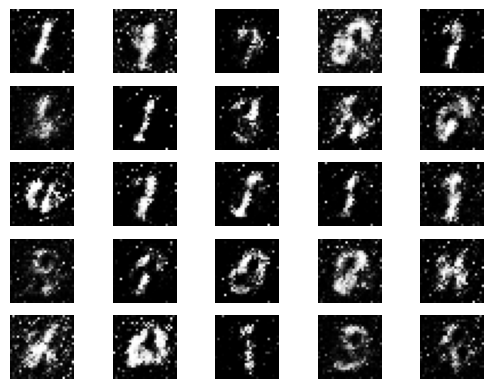

[101/400][0/16] 	Loss_D: 0.5192	Loss_G: -0.2559	D(x): 0.7515	D(G(z)): 0.1176
[102/400][0/16] 	Loss_D: 0.4507	Loss_G: -0.1243	D(x): 0.8607	D(G(z)): 0.2304
[103/400][0/16] 	Loss_D: 0.5883	Loss_G: -0.0959	D(x): 0.9370	D(G(z)): 0.3552
[104/400][0/16] 	Loss_D: 0.3867	Loss_G: -0.1415	D(x): 0.8152	D(G(z)): 0.1150
[105/400][0/16] 	Loss_D: 1.1291	Loss_G: -0.0477	D(x): 0.9379	D(G(z)): 0.5900
[106/400][0/16] 	Loss_D: 0.7679	Loss_G: -0.1723	D(x): 0.7100	D(G(z)): 0.2555
[107/400][0/16] 	Loss_D: 1.0625	Loss_G: -0.0550	D(x): 0.9065	D(G(z)): 0.5727
[108/400][0/16] 	Loss_D: 0.9511	Loss_G: -0.0213	D(x): 0.9484	D(G(z)): 0.5595
[109/400][0/16] 	Loss_D: 0.7560	Loss_G: -0.2998	D(x): 0.6764	D(G(z)): 0.2096
[110/400][0/16] 	Loss_D: 0.7806	Loss_G: -0.4828	D(x): 0.6041	D(G(z)): 0.1053
[111/400][0/16] 	Loss_D: 0.5111	Loss_G: -0.1775	D(x): 0.8158	D(G(z)): 0.2359
[112/400][0/16] 	Loss_D: 0.5862	Loss_G: -0.3993	D(x): 0.7046	D(G(z)): 0.1391
[113/400][0/16] 	Loss_D: 0.6732	Loss_G: -0.2683	D(x): 0.6543	D(G(z)): 0.0779

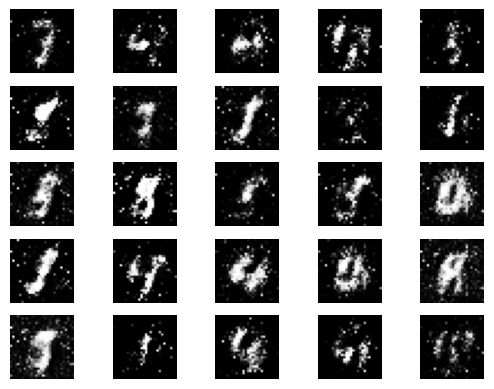

[126/400][0/16] 	Loss_D: 0.5293	Loss_G: -0.2776	D(x): 0.7201	D(G(z)): 0.1320
[127/400][0/16] 	Loss_D: 0.3601	Loss_G: -0.1457	D(x): 0.8077	D(G(z)): 0.0769
[128/400][0/16] 	Loss_D: 0.4622	Loss_G: -0.4676	D(x): 0.7214	D(G(z)): 0.0466
[129/400][0/16] 	Loss_D: 1.0651	Loss_G: -0.7233	D(x): 0.5246	D(G(z)): 0.0721
[130/400][0/16] 	Loss_D: 0.7564	Loss_G: -0.0354	D(x): 0.8878	D(G(z)): 0.4377
[131/400][0/16] 	Loss_D: 0.6825	Loss_G: -0.0502	D(x): 0.9452	D(G(z)): 0.4215
[132/400][0/16] 	Loss_D: 0.9373	Loss_G: -0.8263	D(x): 0.5176	D(G(z)): 0.0256
[133/400][0/16] 	Loss_D: 0.5305	Loss_G: -0.1149	D(x): 0.8344	D(G(z)): 0.2332
[134/400][0/16] 	Loss_D: 0.6014	Loss_G: -0.4598	D(x): 0.7278	D(G(z)): 0.1778
[135/400][0/16] 	Loss_D: 0.4617	Loss_G: -0.1970	D(x): 0.7779	D(G(z)): 0.1210
[136/400][0/16] 	Loss_D: 0.4846	Loss_G: -0.4600	D(x): 0.7083	D(G(z)): 0.0526
[137/400][0/16] 	Loss_D: 0.3853	Loss_G: -0.0853	D(x): 0.8977	D(G(z)): 0.2195
[138/400][0/16] 	Loss_D: 0.4644	Loss_G: -0.1378	D(x): 0.8187	D(G(z)): 0.1939

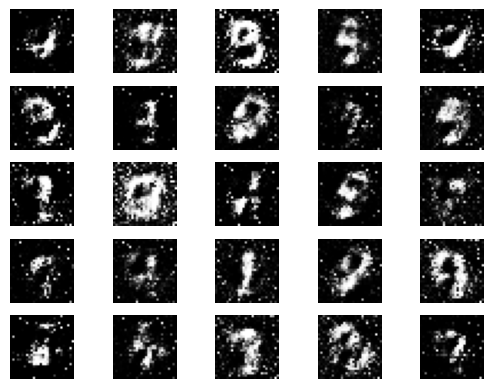

[151/400][0/16] 	Loss_D: 0.8100	Loss_G: -0.0190	D(x): 0.9407	D(G(z)): 0.4735
[152/400][0/16] 	Loss_D: 0.7052	Loss_G: -0.0362	D(x): 0.9111	D(G(z)): 0.4034
[153/400][0/16] 	Loss_D: 0.7293	Loss_G: -0.0563	D(x): 0.9122	D(G(z)): 0.4321
[154/400][0/16] 	Loss_D: 0.3928	Loss_G: -0.0791	D(x): 0.8789	D(G(z)): 0.1949
[155/400][0/16] 	Loss_D: 0.8655	Loss_G: -0.6866	D(x): 0.5389	D(G(z)): 0.0124
[156/400][0/16] 	Loss_D: 0.4740	Loss_G: -0.0640	D(x): 0.9156	D(G(z)): 0.2703
[157/400][0/16] 	Loss_D: 0.3998	Loss_G: -0.2211	D(x): 0.8068	D(G(z)): 0.1204
[158/400][0/16] 	Loss_D: 0.4208	Loss_G: -0.0980	D(x): 0.9050	D(G(z)): 0.2475
[159/400][0/16] 	Loss_D: 0.3177	Loss_G: -0.0538	D(x): 0.8907	D(G(z)): 0.1607
[160/400][0/16] 	Loss_D: 0.3488	Loss_G: -0.1222	D(x): 0.8409	D(G(z)): 0.1061
[161/400][0/16] 	Loss_D: 0.2789	Loss_G: -0.0703	D(x): 0.9027	D(G(z)): 0.1419
[162/400][0/16] 	Loss_D: 0.2801	Loss_G: -0.0751	D(x): 0.8899	D(G(z)): 0.1248
[163/400][0/16] 	Loss_D: 1.5499	Loss_G: -1.3923	D(x): 0.3740	D(G(z)): 0.0061

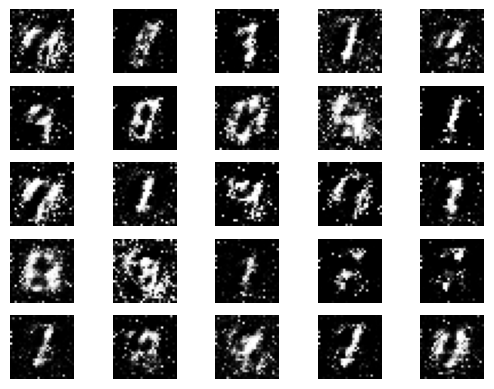

[176/400][0/16] 	Loss_D: 0.3251	Loss_G: -0.1575	D(x): 0.8937	D(G(z)): 0.1674
[177/400][0/16] 	Loss_D: 0.3419	Loss_G: -0.1409	D(x): 0.8688	D(G(z)): 0.1531
[178/400][0/16] 	Loss_D: 0.5968	Loss_G: -0.0678	D(x): 0.9407	D(G(z)): 0.3736
[179/400][0/16] 	Loss_D: 0.4733	Loss_G: -0.1149	D(x): 0.8566	D(G(z)): 0.2198
[180/400][0/16] 	Loss_D: 0.4986	Loss_G: -0.2420	D(x): 0.7893	D(G(z)): 0.1354
[181/400][0/16] 	Loss_D: 0.7094	Loss_G: -0.0453	D(x): 0.9041	D(G(z)): 0.3946
[182/400][0/16] 	Loss_D: 0.5182	Loss_G: -0.0262	D(x): 0.9255	D(G(z)): 0.3174
[183/400][0/16] 	Loss_D: 0.4350	Loss_G: -0.1573	D(x): 0.7934	D(G(z)): 0.1219
[184/400][0/16] 	Loss_D: 0.4952	Loss_G: -0.1277	D(x): 0.7470	D(G(z)): 0.0954
[185/400][0/16] 	Loss_D: 0.4920	Loss_G: -0.1472	D(x): 0.7719	D(G(z)): 0.1249
[186/400][0/16] 	Loss_D: 0.3190	Loss_G: -0.1414	D(x): 0.8205	D(G(z)): 0.0699
[187/400][0/16] 	Loss_D: 1.4552	Loss_G: -1.0417	D(x): 0.4190	D(G(z)): 0.0137
[188/400][0/16] 	Loss_D: 0.5897	Loss_G: -0.2604	D(x): 0.6927	D(G(z)): 0.0977

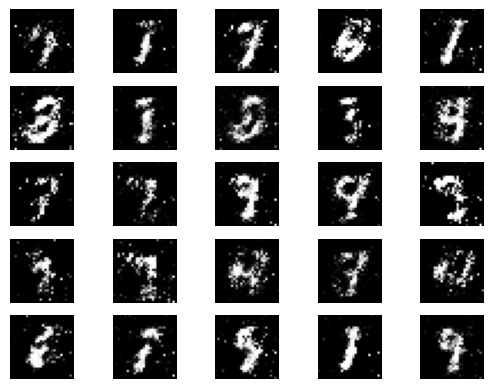

[201/400][0/16] 	Loss_D: 0.7217	Loss_G: -0.4953	D(x): 0.6170	D(G(z)): 0.0664
[202/400][0/16] 	Loss_D: 0.3697	Loss_G: -0.1930	D(x): 0.8024	D(G(z)): 0.0746
[203/400][0/16] 	Loss_D: 0.3013	Loss_G: -0.0839	D(x): 0.9427	D(G(z)): 0.1915
[204/400][0/16] 	Loss_D: 0.8535	Loss_G: -0.0400	D(x): 0.9447	D(G(z)): 0.4708
[205/400][0/16] 	Loss_D: 0.8984	Loss_G: -0.0310	D(x): 0.9278	D(G(z)): 0.4824
[206/400][0/16] 	Loss_D: 0.4442	Loss_G: -0.0889	D(x): 0.9054	D(G(z)): 0.2508
[207/400][0/16] 	Loss_D: 0.7772	Loss_G: -0.0185	D(x): 0.9569	D(G(z)): 0.4462
[208/400][0/16] 	Loss_D: 0.3746	Loss_G: -0.2102	D(x): 0.8062	D(G(z)): 0.0938
[209/400][0/16] 	Loss_D: 0.6273	Loss_G: -0.1058	D(x): 0.8507	D(G(z)): 0.3157
[210/400][0/16] 	Loss_D: 0.7765	Loss_G: -0.5123	D(x): 0.6213	D(G(z)): 0.0817
[211/400][0/16] 	Loss_D: 1.0834	Loss_G: -0.5774	D(x): 0.5215	D(G(z)): 0.0439
[212/400][0/16] 	Loss_D: 0.4149	Loss_G: -0.2001	D(x): 0.8283	D(G(z)): 0.1396
[213/400][0/16] 	Loss_D: 0.5052	Loss_G: -0.0258	D(x): 0.9385	D(G(z)): 0.3142

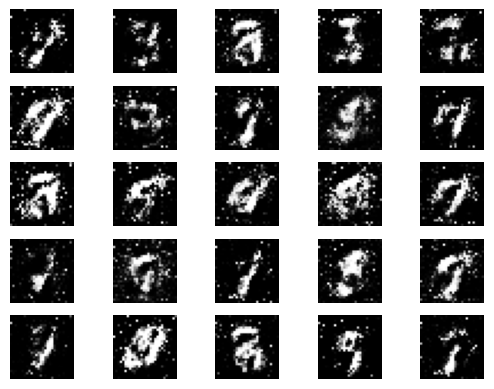

[226/400][0/16] 	Loss_D: 0.4129	Loss_G: -0.1577	D(x): 0.7507	D(G(z)): 0.0558
[227/400][0/16] 	Loss_D: 0.5274	Loss_G: -0.0216	D(x): 0.9220	D(G(z)): 0.3182
[228/400][0/16] 	Loss_D: 0.4257	Loss_G: -0.1088	D(x): 0.8707	D(G(z)): 0.2122
[229/400][0/16] 	Loss_D: 2.5216	Loss_G: -0.0050	D(x): 0.9922	D(G(z)): 0.8451
[230/400][0/16] 	Loss_D: 0.5024	Loss_G: -0.1873	D(x): 0.7224	D(G(z)): 0.0428
[231/400][0/16] 	Loss_D: 0.3751	Loss_G: -0.0502	D(x): 0.9013	D(G(z)): 0.1998
[232/400][0/16] 	Loss_D: 0.4418	Loss_G: -0.2635	D(x): 0.7535	D(G(z)): 0.0496
[233/400][0/16] 	Loss_D: 0.9622	Loss_G: -0.0168	D(x): 0.9527	D(G(z)): 0.5322
[234/400][0/16] 	Loss_D: 0.3475	Loss_G: -0.1831	D(x): 0.8208	D(G(z)): 0.1014
[235/400][0/16] 	Loss_D: 0.3035	Loss_G: -0.1439	D(x): 0.8271	D(G(z)): 0.0521
[236/400][0/16] 	Loss_D: 0.2635	Loss_G: -0.1377	D(x): 0.8590	D(G(z)): 0.0617
[237/400][0/16] 	Loss_D: 0.8187	Loss_G: -0.0212	D(x): 0.9394	D(G(z)): 0.4396
[238/400][0/16] 	Loss_D: 0.4338	Loss_G: -0.0750	D(x): 0.9145	D(G(z)): 0.2462

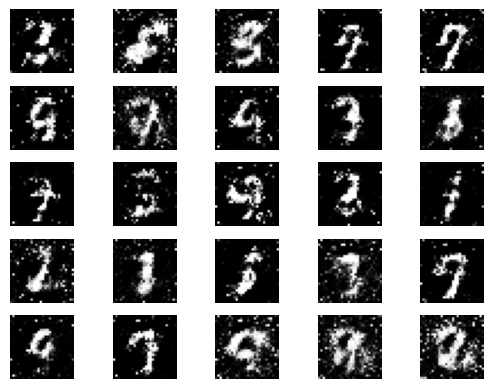

[251/400][0/16] 	Loss_D: 0.5079	Loss_G: -0.0240	D(x): 0.9658	D(G(z)): 0.3397
[252/400][0/16] 	Loss_D: 0.4320	Loss_G: -0.0559	D(x): 0.9192	D(G(z)): 0.2405
[253/400][0/16] 	Loss_D: 0.3679	Loss_G: -0.0800	D(x): 0.9210	D(G(z)): 0.2206
[254/400][0/16] 	Loss_D: 0.5545	Loss_G: -0.3069	D(x): 0.7274	D(G(z)): 0.0649
[255/400][0/16] 	Loss_D: 0.3661	Loss_G: -0.0879	D(x): 0.8829	D(G(z)): 0.1722
[256/400][0/16] 	Loss_D: 0.4248	Loss_G: -0.0377	D(x): 0.9148	D(G(z)): 0.2370
[257/400][0/16] 	Loss_D: 0.6048	Loss_G: -0.5225	D(x): 0.6820	D(G(z)): 0.0744
[258/400][0/16] 	Loss_D: 0.4641	Loss_G: -0.1686	D(x): 0.7728	D(G(z)): 0.1071
[259/400][0/16] 	Loss_D: 0.3365	Loss_G: -0.1201	D(x): 0.8706	D(G(z)): 0.1510
[260/400][0/16] 	Loss_D: 0.3340	Loss_G: -0.0628	D(x): 0.9102	D(G(z)): 0.1828
[261/400][0/16] 	Loss_D: 1.4075	Loss_G: -0.0341	D(x): 0.9690	D(G(z)): 0.6329
[262/400][0/16] 	Loss_D: 0.6131	Loss_G: -0.2585	D(x): 0.7113	D(G(z)): 0.0883
[263/400][0/16] 	Loss_D: 0.4105	Loss_G: -0.2190	D(x): 0.8010	D(G(z)): 0.1239

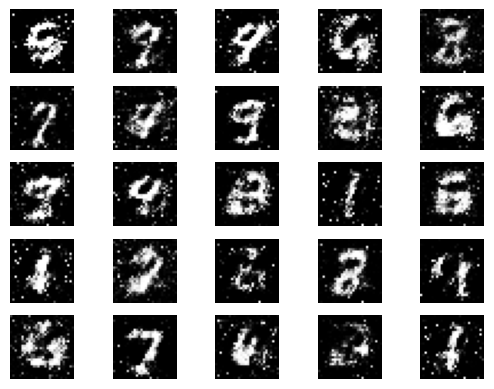

[276/400][0/16] 	Loss_D: 0.3916	Loss_G: -0.0527	D(x): 0.9085	D(G(z)): 0.1986
[277/400][0/16] 	Loss_D: 0.8217	Loss_G: -0.6380	D(x): 0.5739	D(G(z)): 0.0604
[278/400][0/16] 	Loss_D: 0.3665	Loss_G: -0.1503	D(x): 0.8212	D(G(z)): 0.1001
[279/400][0/16] 	Loss_D: 0.4889	Loss_G: -0.3135	D(x): 0.7229	D(G(z)): 0.0576
[280/400][0/16] 	Loss_D: 0.3776	Loss_G: -0.1490	D(x): 0.8342	D(G(z)): 0.1381
[281/400][0/16] 	Loss_D: 0.9708	Loss_G: -0.0319	D(x): 0.9409	D(G(z)): 0.4697
[282/400][0/16] 	Loss_D: 0.5437	Loss_G: -0.0464	D(x): 0.8878	D(G(z)): 0.2946
[283/400][0/16] 	Loss_D: 0.4875	Loss_G: -0.2417	D(x): 0.7339	D(G(z)): 0.0616
[284/400][0/16] 	Loss_D: 0.8624	Loss_G: -0.0190	D(x): 0.9381	D(G(z)): 0.4699
[285/400][0/16] 	Loss_D: 0.5783	Loss_G: -0.3622	D(x): 0.6909	D(G(z)): 0.0653
[286/400][0/16] 	Loss_D: 0.9807	Loss_G: -1.1911	D(x): 0.4859	D(G(z)): 0.0398
[287/400][0/16] 	Loss_D: 0.6051	Loss_G: -0.1571	D(x): 0.7524	D(G(z)): 0.1553
[288/400][0/16] 	Loss_D: 0.3128	Loss_G: -0.1239	D(x): 0.8603	D(G(z)): 0.1191

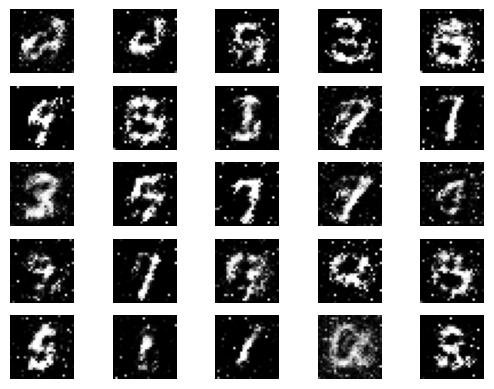

[301/400][0/16] 	Loss_D: 0.6125	Loss_G: -0.0552	D(x): 0.9089	D(G(z)): 0.3272
[302/400][0/16] 	Loss_D: 0.6004	Loss_G: -0.0366	D(x): 0.9144	D(G(z)): 0.3594
[303/400][0/16] 	Loss_D: 0.6760	Loss_G: -0.0304	D(x): 0.9685	D(G(z)): 0.4064
[304/400][0/16] 	Loss_D: 0.4819	Loss_G: -0.0885	D(x): 0.8645	D(G(z)): 0.2488
[305/400][0/16] 	Loss_D: 1.0585	Loss_G: -0.8012	D(x): 0.5144	D(G(z)): 0.0456
[306/400][0/16] 	Loss_D: 0.4798	Loss_G: -0.1114	D(x): 0.8533	D(G(z)): 0.2270
[307/400][0/16] 	Loss_D: 1.5425	Loss_G: -0.8910	D(x): 0.3686	D(G(z)): 0.0095
[308/400][0/16] 	Loss_D: 0.7491	Loss_G: -0.0459	D(x): 0.9487	D(G(z)): 0.4395
[309/400][0/16] 	Loss_D: 0.7541	Loss_G: -0.3527	D(x): 0.6445	D(G(z)): 0.0476
[310/400][0/16] 	Loss_D: 0.3502	Loss_G: -0.0948	D(x): 0.8995	D(G(z)): 0.1881
[311/400][0/16] 	Loss_D: 0.4571	Loss_G: -0.3245	D(x): 0.7674	D(G(z)): 0.0817
[312/400][0/16] 	Loss_D: 1.1745	Loss_G: -0.0298	D(x): 0.9586	D(G(z)): 0.5852
[313/400][0/16] 	Loss_D: 0.3441	Loss_G: -0.0693	D(x): 0.9152	D(G(z)): 0.1995

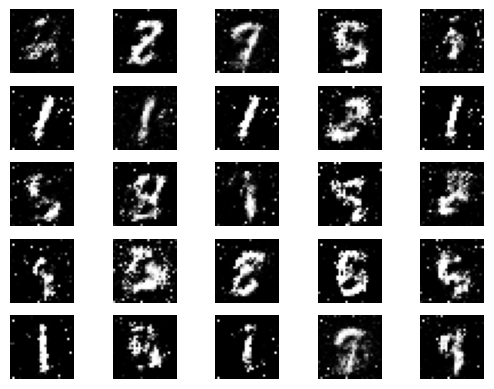

[326/400][0/16] 	Loss_D: 1.0966	Loss_G: -0.0282	D(x): 0.9640	D(G(z)): 0.5590
[327/400][0/16] 	Loss_D: 0.6469	Loss_G: -0.2017	D(x): 0.6605	D(G(z)): 0.0517
[328/400][0/16] 	Loss_D: 0.6130	Loss_G: -0.0828	D(x): 0.9259	D(G(z)): 0.3526
[329/400][0/16] 	Loss_D: 0.3667	Loss_G: -0.1566	D(x): 0.8262	D(G(z)): 0.1142
[330/400][0/16] 	Loss_D: 0.3579	Loss_G: -0.2243	D(x): 0.8396	D(G(z)): 0.1368
[331/400][0/16] 	Loss_D: 0.8964	Loss_G: -0.6469	D(x): 0.5369	D(G(z)): 0.0696
[332/400][0/16] 	Loss_D: 0.7314	Loss_G: -0.3248	D(x): 0.6683	D(G(z)): 0.0847
[333/400][0/16] 	Loss_D: 0.6698	Loss_G: -0.4229	D(x): 0.6459	D(G(z)): 0.1219
[334/400][0/16] 	Loss_D: 0.6919	Loss_G: -0.4337	D(x): 0.6634	D(G(z)): 0.1152
[335/400][0/16] 	Loss_D: 0.5485	Loss_G: -0.0835	D(x): 0.8263	D(G(z)): 0.2533
[336/400][0/16] 	Loss_D: 0.6971	Loss_G: -0.0718	D(x): 0.9111	D(G(z)): 0.3855
[337/400][0/16] 	Loss_D: 1.5198	Loss_G: -0.0175	D(x): 0.9697	D(G(z)): 0.6811
[338/400][0/16] 	Loss_D: 0.6343	Loss_G: -0.3678	D(x): 0.7443	D(G(z)): 0.2000

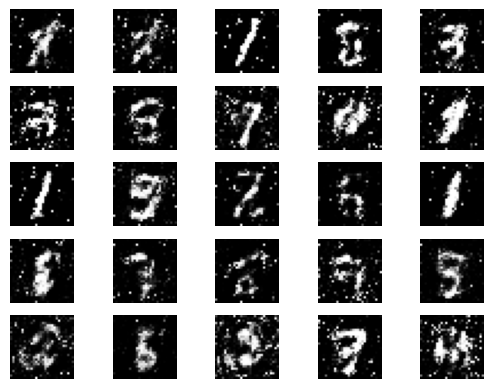

[351/400][0/16] 	Loss_D: 0.7922	Loss_G: -0.0574	D(x): 0.9632	D(G(z)): 0.4446
[352/400][0/16] 	Loss_D: 0.3307	Loss_G: -0.1963	D(x): 0.8486	D(G(z)): 0.1231
[353/400][0/16] 	Loss_D: 0.8336	Loss_G: -0.0669	D(x): 0.9531	D(G(z)): 0.4587
[354/400][0/16] 	Loss_D: 0.4572	Loss_G: -0.1512	D(x): 0.7626	D(G(z)): 0.0947
[355/400][0/16] 	Loss_D: 0.3366	Loss_G: -0.0818	D(x): 0.8954	D(G(z)): 0.1699
[356/400][0/16] 	Loss_D: 0.4171	Loss_G: -0.1452	D(x): 0.8087	D(G(z)): 0.1007
[357/400][0/16] 	Loss_D: 0.4033	Loss_G: -0.0715	D(x): 0.8820	D(G(z)): 0.2130
[358/400][0/16] 	Loss_D: 0.8817	Loss_G: -0.0136	D(x): 0.9607	D(G(z)): 0.4993
[359/400][0/16] 	Loss_D: 0.3997	Loss_G: -0.2436	D(x): 0.8069	D(G(z)): 0.1188
[360/400][0/16] 	Loss_D: 0.5860	Loss_G: -0.4185	D(x): 0.7190	D(G(z)): 0.1160
[361/400][0/16] 	Loss_D: 0.3639	Loss_G: -0.0510	D(x): 0.8765	D(G(z)): 0.1636
[362/400][0/16] 	Loss_D: 0.4447	Loss_G: -0.2514	D(x): 0.7610	D(G(z)): 0.0788
[363/400][0/16] 	Loss_D: 0.5869	Loss_G: -0.2356	D(x): 0.8330	D(G(z)): 0.2358

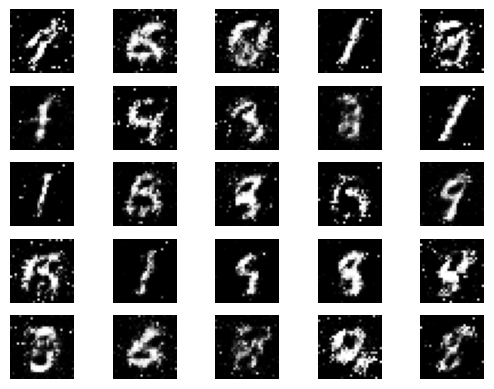

[376/400][0/16] 	Loss_D: 0.5913	Loss_G: -0.5121	D(x): 0.6841	D(G(z)): 0.0710
[377/400][0/16] 	Loss_D: 1.4350	Loss_G: -1.0522	D(x): 0.4340	D(G(z)): 0.0188
[378/400][0/16] 	Loss_D: 0.4654	Loss_G: -0.2243	D(x): 0.7396	D(G(z)): 0.0699
[379/400][0/16] 	Loss_D: 0.6029	Loss_G: -0.2053	D(x): 0.8383	D(G(z)): 0.2889
[380/400][0/16] 	Loss_D: 0.4824	Loss_G: -0.1372	D(x): 0.8184	D(G(z)): 0.1929
[381/400][0/16] 	Loss_D: 0.5570	Loss_G: -0.2164	D(x): 0.7894	D(G(z)): 0.1920
[382/400][0/16] 	Loss_D: 0.7387	Loss_G: -0.8250	D(x): 0.6046	D(G(z)): 0.0811
[383/400][0/16] 	Loss_D: 0.8828	Loss_G: -0.0387	D(x): 0.9234	D(G(z)): 0.4689
[384/400][0/16] 	Loss_D: 0.5082	Loss_G: -0.2698	D(x): 0.7397	D(G(z)): 0.0837
[385/400][0/16] 	Loss_D: 0.4162	Loss_G: -0.1557	D(x): 0.7840	D(G(z)): 0.0922
[386/400][0/16] 	Loss_D: 0.8654	Loss_G: -0.8355	D(x): 0.5411	D(G(z)): 0.0440
[387/400][0/16] 	Loss_D: 0.5142	Loss_G: -0.1199	D(x): 0.8779	D(G(z)): 0.2767
[388/400][0/16] 	Loss_D: 0.7084	Loss_G: -0.2951	D(x): 0.7714	D(G(z)): 0.2845

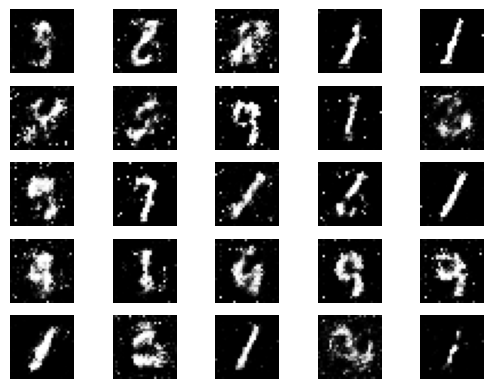

In [153]:

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0] # FILL IN HERE
      true_labels = torch.ones((true_imgs.size(0), 1)) # FILL IN HERE
      # put true data through discriminator
      d_output_true = disc_model.forward(true_imgs) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.randn(true_imgs.size(0), z_dim) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise) # FILL IN HERE
  
      fake_labels = torch.zeros((true_imgs.size(0), 1)) # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model.forward(fake_imgs) # FILL IN HERE
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels) # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(gen_model(z_latent_noise)) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

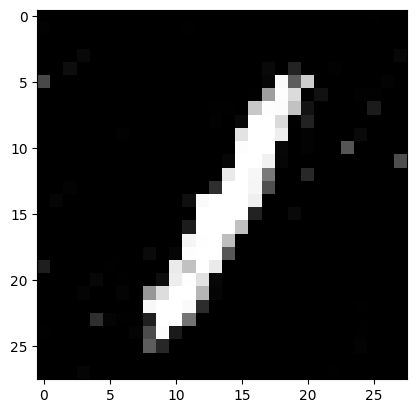

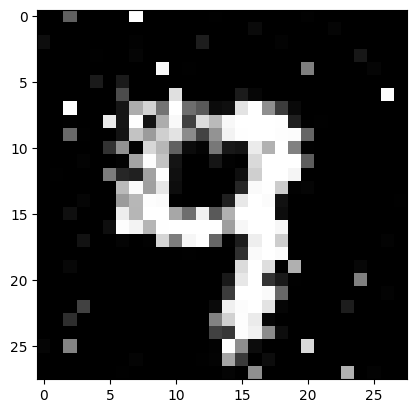

In [154]:
# first image
random_seed = 105 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.randn(z_dim) # FILL IN HERE
x_0 = 0.5*gen_model(z_0) + 0.5 # FILL IN HERE

random_seed = 73 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.randn(z_dim) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE

# display images
plt.imshow(x_0[0].detach().numpy().reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_1[0].detach().numpy().reshape(28, 28), cmap='gray')
plt.show()
# FILL IN HERE

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [155]:
n_interpolation = 20

interpolated_z = []
# FILL IN HERE
interpolated_z.append(z_0)
factor = (z_1 - z_0) / (n_interpolation - 1)
last_vec = z_0
for i in range(n_interpolation - 1):
  last_vec = last_vec + factor
  interpolated_z.append(last_vec)

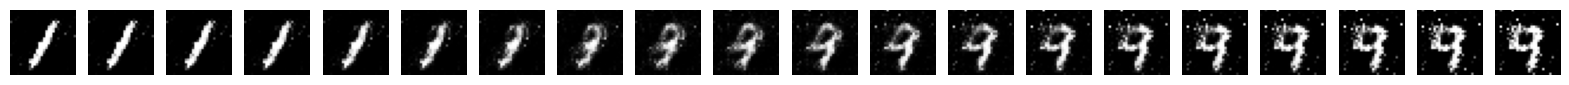

In [156]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
imgs = []
for i in range(n_interpolation):
  #black and white images
  img = gen_model(interpolated_z[i])
  imgs.append(img)
  img = img[0].detach().numpy().reshape(28, 28)
  axs[i].imshow(img, cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__
Although the images themselves aren't in their higher quality (the resolution is also 28 x 28) we can see a great transition between the number one and the number nine.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [157]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(14*14*n_h_2, nb_classes),
) # FILL IN CODE HERE

criterion = nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [158]:
# training the classifier

# FILL IN HERE
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0148 Accuracy:0.8000
Epoch:1 Train Loss:0.0058 Accuracy:0.9250
Epoch:2 Train Loss:0.0039 Accuracy:0.9250
Epoch:3 Train Loss:0.0004 Accuracy:1.0000
Epoch:4 Train Loss:0.0006 Accuracy:1.0000
Epoch:5 Train Loss:0.0003 Accuracy:1.0000
Epoch:6 Train Loss:0.0001 Accuracy:1.0000
Epoch:7 Train Loss:0.0000 Accuracy:1.0000
Epoch:8 Train Loss:0.0000 Accuracy:1.0000
Epoch:9 Train Loss:0.0000 Accuracy:1.0000
Epoch:10 Train Loss:0.0000 Accuracy:1.0000
Epoch:11 Train Loss:0.0000 Accuracy:1.0000
Epoch:12 Train Loss:0.0000 Accuracy:1.0000
Epoch:13 Train Loss:0.0000 Accuracy:1.0000
Epoch:14 Train Loss:0.0000 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0000 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [171]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(F.softmax(classification_model(imgs_in)), dim=1) # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [172]:
z_classes = predict_mnist_class(imgs, mnist_classification_model) # FILL IN HERE
print(z_classes)

tensor([6, 9, 0, 6, 2, 6, 3, 2, 6, 1, 2, 8, 6, 6, 8, 4, 9, 4, 3, 5, 3, 4, 2, 9,
        6, 5, 7, 6, 8, 9, 4, 1, 6, 1, 1, 6, 2, 3, 0, 2])


<ipython-input-171-0337ff7cf444>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_classes = torch.argmax(F.softmax(classification_model(imgs_in)), dim=1) # FILL IN HERE


__Answer__

Yes, it traverses others classes, actually not even the first was well classified, we had a lot of misclassification.







### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [175]:
def predict_mnist_confidence(imgs_in,classification_model):
  score = torch.max(F.softmax(classification_model(imgs_in), dim=1), dim=1) # FILL IN HERE
  return(score)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [176]:
z_confidence = predict_mnist_confidence(imgs, mnist_classification_model) #FILL IN HERE
print(z_confidence)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9992, 1.0000,
        1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9994, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9985, 1.0000, 1.0000,
        1.0000, 0.9997, 1.0000, 1.0000], grad_fn=<MaxBackward0>),
indices=tensor([6, 9, 0, 6, 2, 6, 3, 2, 6, 1, 2, 8, 6, 6, 8, 4, 9, 4, 3, 5, 3, 4, 2, 9,
        6, 5, 7, 6, 8, 9, 4, 1, 6, 1, 1, 6, 2, 3, 0, 2]))


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__
The confidence interval is a bit unstable since our interpolation in the latent space leads to vectors that generate images that aren’t alike any number, which may cause this instability.

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [163]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

100%|██████████| 170498071/170498071 [00:13<00:00, 12867495.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Files already downloaded and verified


Now, we can redefine the hyper-parameters of the model (change if you wish)

In [164]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [165]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [166]:
# training code

# FILL IN HERE